# angular acceptance plots

here, we want to obtain a PDF for the angular acceptance of the P-OM. We proceed the following way:
+ obtain a dataset of homogenous illumination of the P-OM. data can be pre-filtered by glass contact.
+ we need to evaluate and bin the data on: angular distance from the PMT normal vector to the glass intersection, photon-phi-to-PMT, photon-theta-to-glass, contact point with glass.
+ assuming some symmetries, we track the amount of detected photons in three plots:
  + phi/theta
  + ang-dist/theta
  + ang-dist/phi
+ we also want a heatmap on positional angular acceptance for the entire hemisphere. Here, we can give an overall percentage of photons detected.
+ Last, we want a total percentage: photons detected / photons on glass

### imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

### histogram preparation

we need to anticipate big datasets in multiple files. we thereby fill the histograms sequentially with one file open at a time. For the first view histograms, we only keep track of detected photons, as the histograms properties are defined through the PMT the photon was detected in. For the Glass positions, we kep track of all photons and want to give a percentage of photons detected per point on the glass. Fist we create the histograms as empty arrays:

In [2]:
# angular distance to direction phi
hist_d_a_p_x_edges = np.linspace(start=0, stop=np.pi, num=500)
hist_d_a_p_y_edges = np.linspace(start=0, stop=np.pi, num=500)
hist_detect_angulardistance_to_phi = np.zeros((len(hist_d_a_p_x_edges)-1, len(hist_d_a_p_y_edges)-1))

# angular distance to direction theta
hist_d_a_t_x_edges = np.linspace(start=0, stop=np.pi/2, num=500)
hist_d_a_t_y_edges = np.linspace(start=0, stop=np.pi/2, num=500)
hist_detect_angulardistance_to_theta = np.zeros((len(hist_d_a_t_x_edges)-1, len(hist_d_a_t_y_edges)-1))

# direction theta to phi
hist_d_t_p_x_edges = np.linspace(start=0, stop=np.pi, num=500)
hist_d_t_p_y_edges = np.linspace(start=0, stop=np.pi, num=500)
hist_detect_theta_to_phi = np.zeros((len(hist_d_t_p_x_edges)-1, len(hist_d_t_p_y_edges)-1))

# position phi to position theta
hist_g_p_p_t_x_edges = np.linspace(start=-np.pi, stop=np.pi, num=500)
hist_g_p_p_t_y_edges = np.linspace(start=-np.pi/2, stop=np.pi/2, num=500)
hist_global_pos_phi_to_theta = np.zeros((len(hist_g_p_p_t_x_edges)-1, len(hist_g_p_p_t_y_edges)-1))

hist_d_p_p_t_x_edges = np.linspace(start=-np.pi, stop=np.pi, num=500)
hist_d_p_p_t_y_edges = np.linspace(start=-np.pi/2, stop=np.pi/2, num=500)
hist_detect_pos_phi_to_theta = np.zeros((len(hist_d_p_p_t_x_edges)-1, len(hist_d_p_p_t_y_edges)-1))

we also need to hand over the pmt positions:

In [3]:
# PMT position dict containing the angles for each PMT
pmt_positions = {
    0:  (     0,     25),
    1:  (    90,     25),
    2:  (   180,     25),
    3:  ( -  90,     25),
    4:  (    45,   57.5),
    5:  (   135,   57.5),
    6:  ( - 135,   57.5),
    7:  ( -  45,   57.5),
    8:  (    90, -   25),
    9:  (     0, -   25),
    10: ( -  90, -   25),
    11: (   180, -   25),
    12: (    45, - 57.5),
    13: ( -  45, - 57.5),
    14: ( - 135, - 57.5),
    15: (   135, - 57.5),
}

then we need to create a function that reads in a data file, prepares it, extracts the necessary data and fills the histograms:

In [4]:
def extract_data_to_histograms(datafile):

    # reference global histograms
    global hist_detect_angulardistance_to_phi
    global hist_detect_angulardistance_to_theta
    global hist_detect_theta_to_phi
    global hist_global_pos_phi_to_theta
    global hist_detect_pos_phi_to_theta

    # read in data
    df = pd.read_csv(datafile)
    df = df.query("PID == -22 and g_x != 0 and g_y != 0 and g_z != 0")

    # subtract flange from g_z
    flange_thickness = 90 # mm
    df['g_z'] = df['g_z'] - flange_thickness/2 * np.sign(df['g_z'])

    # calculate position properties
    photons_pos_r      = np.sqrt(df['g_x']**2 + df['g_y']**2 + (df['g_z'])**2)
    photons_pos_theta  = np.pi/2 - np.arccos((df['g_z'])/photons_pos_r)
    photons_pos_phi    = np.arctan2(df['g_y'], df['g_x'])
    photons_pos_angles = np.array([photons_pos_phi, photons_pos_theta]).T

    # get global histogram data
    hist_global_pos_phi_to_theta = hist_global_pos_phi_to_theta + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_g_p_p_t_x_edges, hist_g_p_p_t_y_edges])[0]

    # filter df by detected photons
    df = df.query("out_ProcessName == 'OpAbsorption' and out_VolumeName.str.contains('photocathode')")

    # get position properties on filtered dataset
    photons_pos_r      = np.sqrt(df['g_x']**2 + df['g_y']**2 + (df['g_z'])**2)
    photons_pos_theta  = np.pi/2 - np.arccos((df['g_z'])/photons_pos_r)
    photons_pos_phi    = np.arctan2(df['g_y'], df['g_x'])
    photons_pos_angles = np.array([photons_pos_phi, photons_pos_theta]).T

    # angular distances
    pmt_positions_for_photons           = np.take(np.deg2rad(list(pmt_positions.values())), df['out_Volume_CopyNo'], axis=0)
    photons_angular_distances_to_pmts   = np.arccos( np.sin(photons_pos_angles[:,1]) * np.sin(pmt_positions_for_photons[:,1])
                                                   + np.cos(photons_pos_angles[:,1]) * np.cos(pmt_positions_for_photons[:,1])
                                                   * np.cos(photons_pos_angles[:,0]  - pmt_positions_for_photons[:,0]))
    
    # theta (assuming position is normal vector to glass).
    photon_g_position = np.array([df['g_x'], df['g_y'], df['g_z']]).T
    photon_g_momentum = np.array([df['g_px'], df['g_py'], df['g_pz']]).T
    photon_dir_theta  = np.arccos(np.clip(np.sum( - photon_g_position * photon_g_momentum, axis=1) / (np.linalg.norm(photon_g_position, axis=1) * np.linalg.norm(photon_g_momentum, axis=1)), -1.0, 1.0))

    # phi
    pmt_pos_vectors_for_photons = np.array([photons_pos_r*np.sin(np.pi/2 - pmt_positions_for_photons[:,1]) * np.cos(pmt_positions_for_photons[:,0]),
                                            photons_pos_r*np.sin(np.pi/2 - pmt_positions_for_photons[:,1]) * np.sin(pmt_positions_for_photons[:,0]),
                                            photons_pos_r*np.cos(np.pi/2 - pmt_positions_for_photons[:,1])]).T
    vector_g_to_pmt = pmt_pos_vectors_for_photons - photon_g_position

    projection_vector_g_to_pmt   = vector_g_to_pmt   - (np.sum(vector_g_to_pmt   * photon_g_position, axis=1) / np.linalg.norm(photon_g_position, axis=1)**2)[:,np.newaxis] * photon_g_position
    projection_photon_g_momentum = photon_g_momentum - (np.sum(photon_g_momentum * photon_g_position, axis=1) / np.linalg.norm(photon_g_position, axis=1)**2)[:,np.newaxis] * photon_g_position

    photon_dir_phi = np.arccos(np.clip(np.sum(projection_vector_g_to_pmt * projection_photon_g_momentum, axis=1) / (np.linalg.norm(projection_vector_g_to_pmt, axis=1) * np.linalg.norm(projection_photon_g_momentum, axis=1)), -1.0, 1.0))

    # fill histograms
    hist_detect_angulardistance_to_phi   = hist_detect_angulardistance_to_phi   + np.histogram2d(photons_angular_distances_to_pmts,photon_dir_phi, bins=[hist_d_a_p_x_edges, hist_d_a_p_y_edges])[0]
    hist_detect_angulardistance_to_theta = hist_detect_angulardistance_to_theta + np.histogram2d(photons_angular_distances_to_pmts,photon_dir_theta, bins=[hist_d_a_t_x_edges, hist_d_a_t_y_edges])[0]
    hist_detect_theta_to_phi             = hist_detect_theta_to_phi             + np.histogram2d(photon_dir_theta,photon_dir_phi, bins=[hist_d_t_p_x_edges, hist_d_t_p_y_edges])[0]
    hist_detect_pos_phi_to_theta         = hist_detect_pos_phi_to_theta         + np.histogram2d(photons_pos_phi,photons_pos_theta, bins=[hist_d_p_p_t_x_edges, hist_d_p_p_t_y_edges])[0]

### data extraction and histogram filling

In [5]:
folder_path = '/home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data'

for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and filename.startswith("out_photons"):
        datafile = os.path.join(folder_path, filename)
        print(f"going through {datafile}")
        extract_data_to_histograms(datafile)

going through /home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data/out_photons_open_frame.csv
going through /home/nretza/ECP_libraries/Geant4-Simulations/P-OM/data/out_photons_closed_frame.csv


### ploting

First, we plot the acceptance heatmap on the sphere:

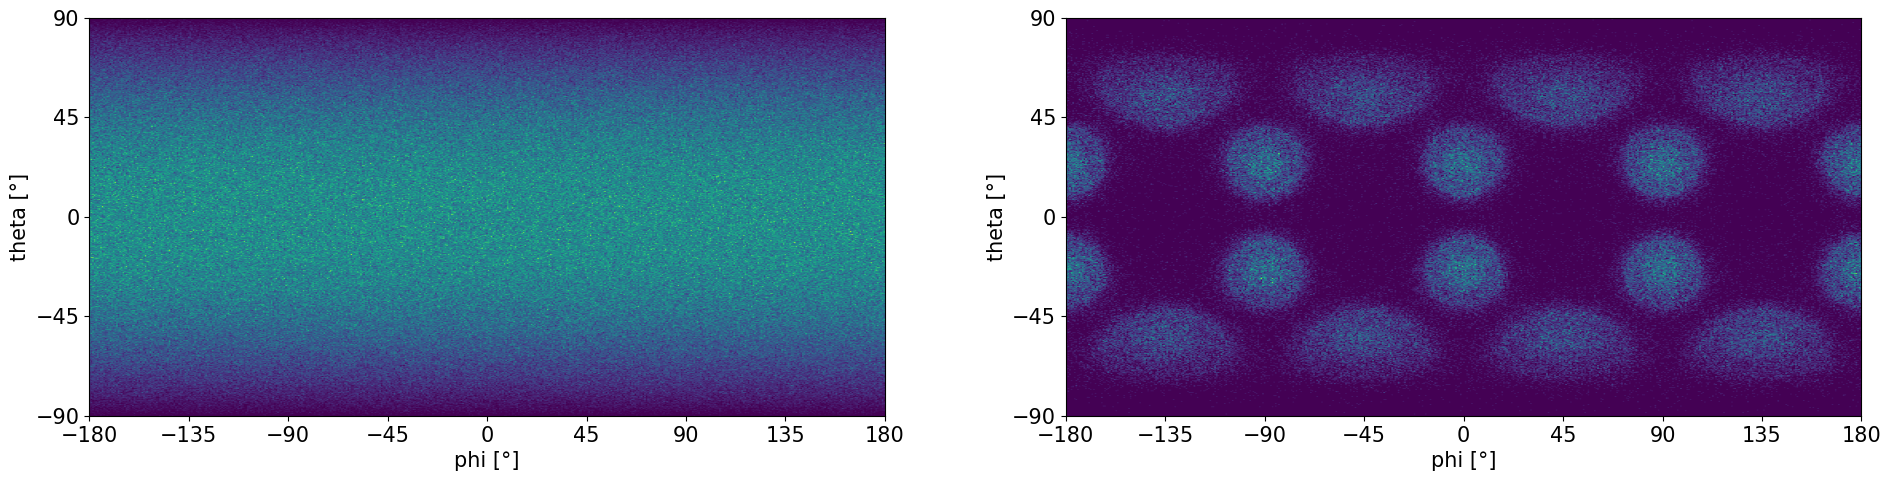

In [6]:
fig, ax = plt.subplots(1, 2)#, subplot_kw=dict(projection='mollweide'))
fig.tight_layout()
fig.set_size_inches(20, 20)

dpi        = 200
font_size  = 15
ticks      = 45

extent_g = np.rad2deg([hist_g_p_p_t_x_edges[0], hist_g_p_p_t_x_edges[-1], hist_g_p_p_t_y_edges[0], hist_g_p_p_t_y_edges[-1]])
extent_d = np.rad2deg([hist_d_p_p_t_x_edges[0], hist_d_p_p_t_x_edges[-1], hist_d_p_p_t_y_edges[0], hist_d_p_p_t_y_edges[-1]])

ax[0].imshow(hist_global_pos_phi_to_theta.T, extent=extent_g, origin='lower')

ax[0].set_xlabel('phi [°]', fontsize = font_size)
ax[0].set_ylabel('theta [°]', fontsize = font_size)
ax[0].tick_params(axis='both', which='major', labelsize=font_size)
ax[0].xaxis.set_ticks(np.arange(extent_g[0], extent_g[1] + ticks, ticks))
ax[0].yaxis.set_ticks(np.arange(extent_g[2], extent_g[3] + ticks, ticks))

ax[1].imshow(hist_detect_pos_phi_to_theta.T, extent=extent_d, origin='lower')

ax[1].set_xlabel('phi [°]', fontsize = font_size)
ax[1].set_ylabel('theta [°]', fontsize = font_size)
ax[1].tick_params(axis='both', which='major', labelsize=font_size)
ax[1].xaxis.set_ticks(np.arange(extent_d[0], extent_d[1] + ticks, ticks))
ax[1].yaxis.set_ticks(np.arange(extent_d[2], extent_d[3] + ticks, ticks));


and the angular acceptance dependant on the three parameters from above:

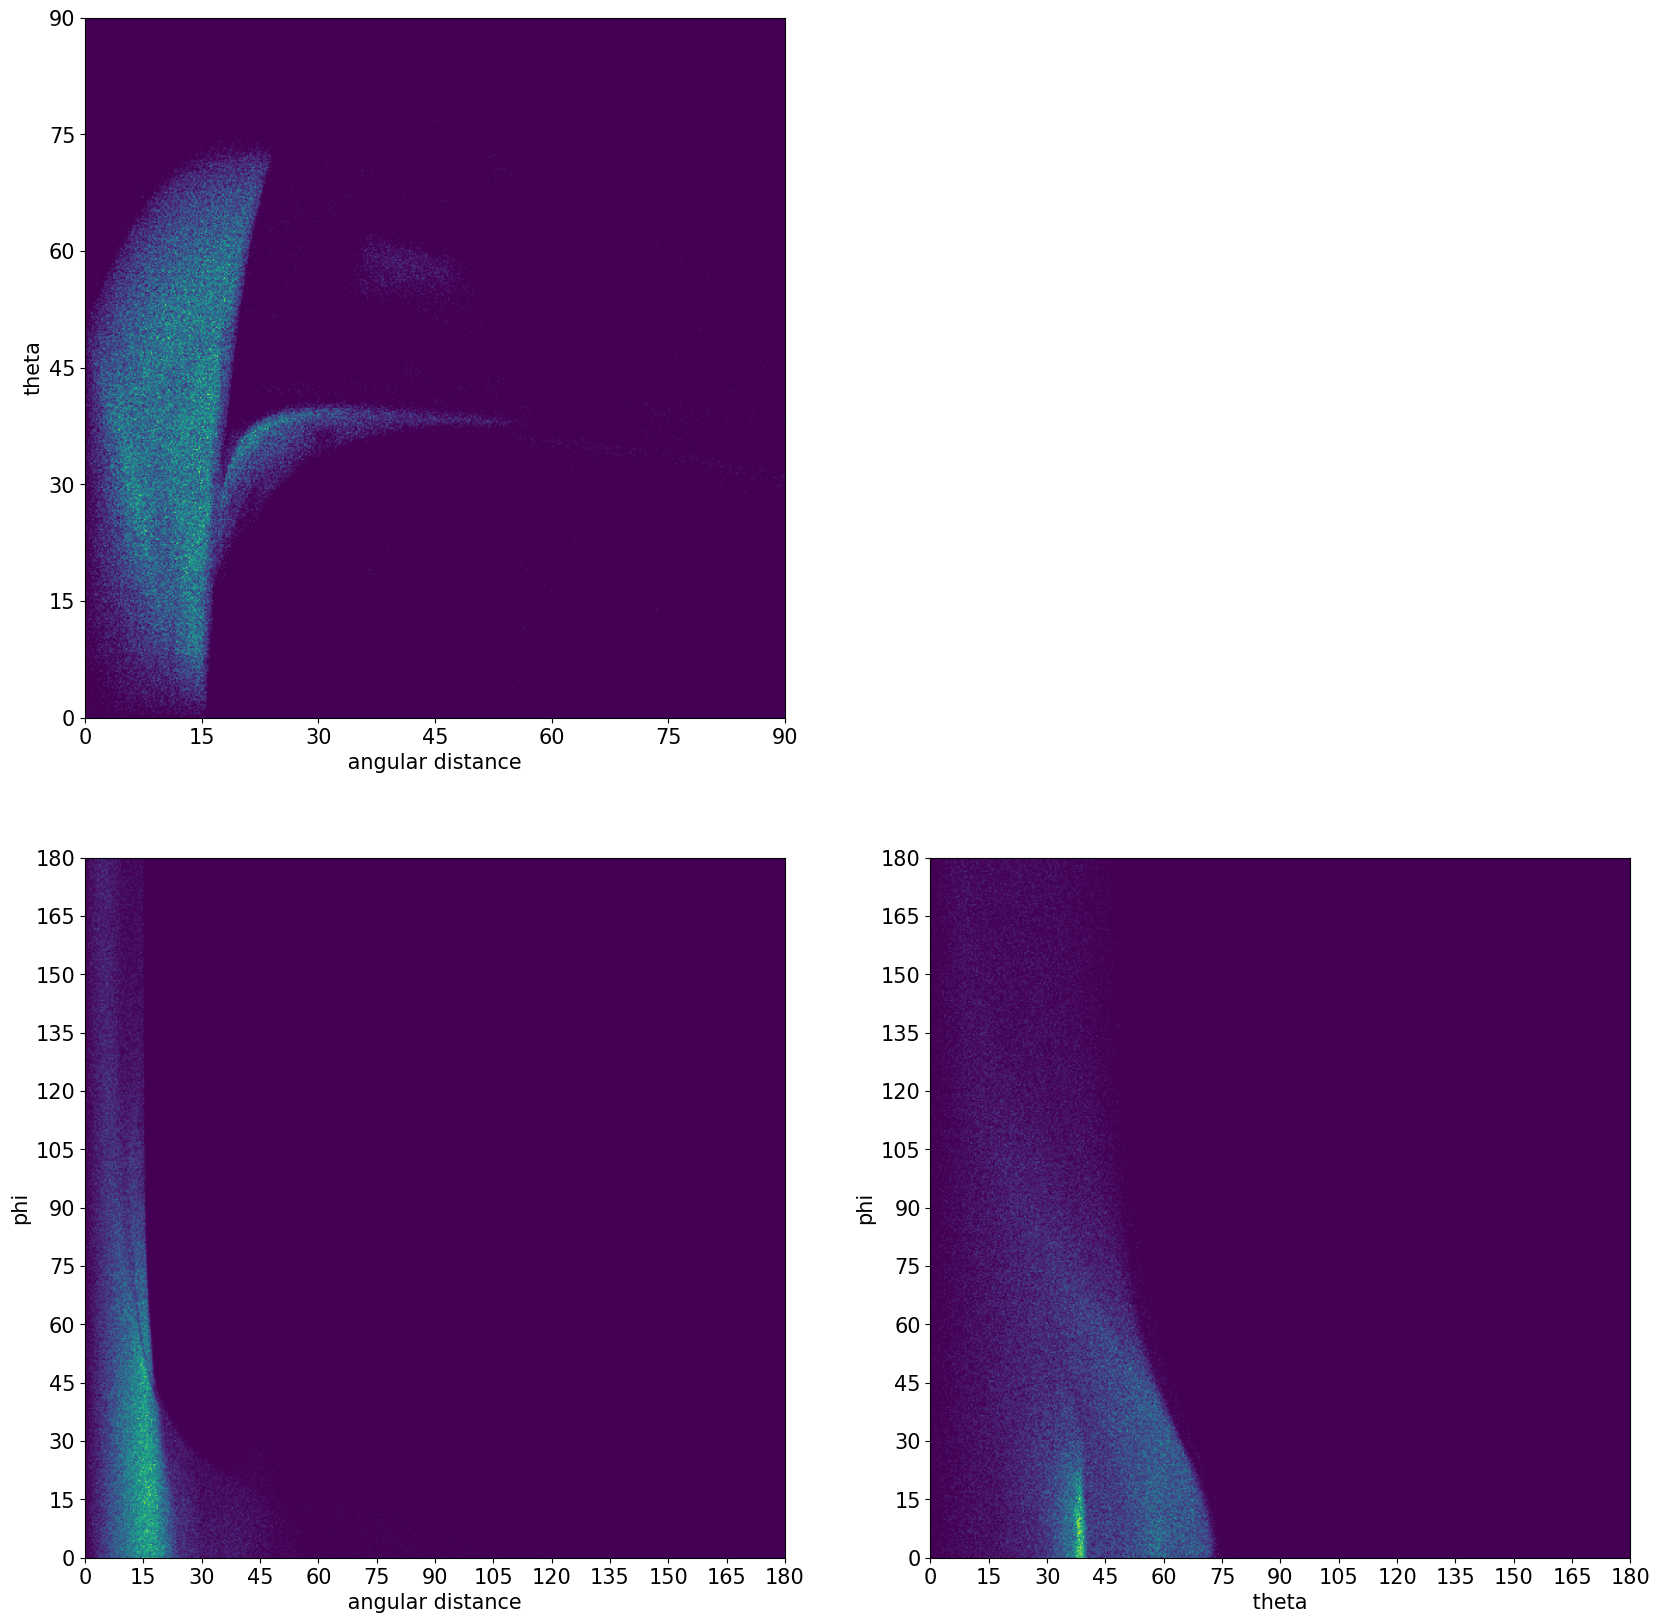

In [7]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 2)
fig.set_size_inches(20, 20)

dpi        = 200
font_size  = 15
ticks      = 15

ax_1 = fig.add_subplot(2,2,1)
ax_2 = fig.add_subplot(2,2,3)
ax_3 = fig.add_subplot(2,2,4)

extend_d_a_t = np.rad2deg([hist_d_a_t_x_edges[0], hist_d_a_t_x_edges[-1], hist_d_a_t_y_edges[0], hist_d_a_t_y_edges[-1]])
extend_d_a_p = np.rad2deg([hist_d_a_p_x_edges[0], hist_d_a_p_x_edges[-1], hist_d_a_p_y_edges[0], hist_d_a_p_y_edges[-1]])
extend_d_t_p = np.rad2deg([hist_d_t_p_x_edges[0], hist_d_t_p_x_edges[-1], hist_d_t_p_y_edges[0], hist_d_t_p_y_edges[-1]])

ax_1.imshow(hist_detect_angulardistance_to_theta.T, extent=extend_d_a_t, origin='lower')
ax_1.set_xlabel(' angular distance [°]', fontsize = font_size)
ax_1.set_ylabel('theta [°]', fontsize = font_size)
ax_1.tick_params(axis='both', which='major', labelsize=font_size)
ax_1.xaxis.set_ticks(np.arange(extend_d_a_t[0], extend_d_a_t[1] + ticks, ticks))
ax_1.yaxis.set_ticks(np.arange(extend_d_a_t[2], extend_d_a_t[3] + ticks, ticks))

ax_2.imshow(hist_detect_angulardistance_to_phi.T, extent=extend_d_a_p, origin='lower')
ax_2.set_xlabel(' angular distance [°]', fontsize = font_size)
ax_2.set_ylabel('phi [°]', fontsize = font_size)
ax_2.tick_params(axis='both', which='major', labelsize=font_size)
ax_2.xaxis.set_ticks(np.arange(extend_d_a_p[0], extend_d_a_p[1] + ticks, ticks))
ax_2.yaxis.set_ticks(np.arange(extend_d_a_p[2], extend_d_a_p[3] + ticks, ticks))

ax_3.imshow(hist_detect_theta_to_phi.T, extent=extend_d_t_p, origin='lower')
ax_3.set_xlabel(' theta [°]', fontsize = font_size)
ax_3.set_ylabel('phi [°]', fontsize = font_size)
ax_3.tick_params(axis='both', which='major', labelsize=font_size)
ax_3.xaxis.set_ticks(np.arange(extend_d_t_p[0], extend_d_t_p[1] + ticks, ticks))
ax_3.yaxis.set_ticks(np.arange(extend_d_t_p[2], extend_d_t_p[3] + ticks, ticks));

as well as the total acceptance percentage:

In [1]:
total_photons_global = hist_global_pos_phi_to_theta.sum()
total_photons_detect = hist_detect_pos_phi_to_theta.sum()

percent = float(total_photons_detect) / float(total_photons_global)

print(f"Total detection ptobability: {round(percent, 2)} %")

NameError: name 'hist_global_pos_phi_to_theta' is not defined